## Predict which Tweets are about real disasters and which ones are not

In [1]:
# importing general packages
import numpy as np
import pandas as pd

# importing packages for text pre-porcessing
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup # package used for web scrapping to remove the HTML tags from the text ( not needed here)
import re # A package dealing with regular experession to remove punctuation and numbers
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet

# importing packages for vectorization of text data
from sklearn.feature_extraction.text import CountVectorizer # bag of words vectorization
from sklearn.feature_extraction.text import TfidfVectorizer # Tf - idf vectorization
from sklearn.preprocessing import LabelEncoder

#importing packages for model-building
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import itertools
import matplotlib.pyplot as plt

#hiding all warnings
import warnings
warnings.filterwarnings('ignore')



### 1. Importing text data

In [2]:
# Importing data
data = pd.read_csv("data/train.csv")
# data.set_index('id',inplace = True) # making the tweet id as index 
validation_data = pd.read_csv("data/test.csv")
# validation_data.set_index('id',inplace = True) # making the tweet id as index

#adding the keyword to the text in the beggining to increase the weightage of the keyword in the tweet
for i in range(len(data)):
    if not pd.isna(data.iat[i,1]):
        data.iat[i,3] = str(data.iat[i,1])+ " " + data.iat[i,3]

for i in range(len(validation_data)):
    if not pd.isna(validation_data.iat[i,1]):
        validation_data.iat[i,3] = str(validation_data.iat[i,1])+ " " + validation_data.iat[i,3]


### 2. Data Cleaning and preprocessing

In [3]:
# Removing irrelevant columns
data = data.drop(['keyword','location'], axis = 1)
validation_data = validation_data.drop(['keyword','location'], axis = 1) # data for model validation and submission
data

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1


In [4]:
validation_data

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [5]:
# function to clean data

# initializing stemming algorithm
ps = PorterStemmer() # porter stemmer
ss = SnowballStemmer('english') # snowball stemmer
# initializing lemmatizing algorithm
wnl = WordNetLemmatizer() # lemmatization
def text_clean_preprocess(raw_text : str):
    """
    This function will clean the data and perform certain preprocessing step of stemming/lemmatizing the words in 
    the tweet. Finally the function will remove stopwords and will only consider with words with a character length
    ranging from 2 to 10
    
    """
    vowel = ['a','e','i','o','u']
    text = BeautifulSoup(raw_text) # using the BeautifulSoup library to scrape the HTML tags from the text
    text = re.sub("[^a-zA-Z]"," ",text.get_text()) # removing all the punctions except the expressions ":)" and ":("
    text = text.lower() # converting all words to lowercase
    text = text.strip() # striping leading and trailing white spaces
    words = text.split()
    meaningful_words = [ss.stem(w) for w in words if w not in stopwords.words("english") and 2< len(w)<=15]
    return " ".join(meaningful_words)  
    

In [6]:
clean_tweets = [] # list to store all the cleaned tweets from the training data
clean_tweets_validation = [] # list to store all the cleaned tweets from validation data
for tweet in data['text']:
    clean_tweet = text_clean_preprocess(tweet)
    clean_tweets.append(clean_tweet)
for tweet in validation_data['text']:
    clean_tweet = text_clean_preprocess(tweet)
    clean_tweets_validation.append(clean_tweet)

In [7]:
clean_tweets

['deed reason earthquak may allah forgiv',
 'forest fire near rong sask canada',
 'resid ask shelter place notifi offic evacu shelter place order expect',
 'peopl receiv wildfir evacu order california',
 'got sent photo rubi alaska smoke wildfir pour school',
 'rockyfir updat california hwi close direct due lake counti fire cafir wildfir',
 'flood disast heavi rain caus flash flood street manitou colorado spring area',
 'top hill see fire wood',
 'emerg evacu happen build across street',
 'afraid tornado come area',
 'three peopl die heat wave far',
 'haha south tampa get flood hah wait second live south tampa gonna gonna fvck flood',
 'rain flood florida tampabay tampa day lost count',
 'flood bago myanmar arriv bago',
 'damag school bus multi car crash break',
 'man',
 'love fruit',
 'summer love',
 'car fast',
 'goooooooaaaaaal',
 'ridicul',
 'london cool',
 'love ski',
 'wonder day',
 'looooool',
 'way eat shit',
 'nyc last week',
 'love girlfriend',
 'cooool',
 'like pasta',
 'end

In [8]:
# Presenting the clean data in a dataframe
clean_data = pd.DataFrame(list(zip(data['id'],clean_tweets,data['target'])),columns = ['id','text','target'])
clean_data_validation = pd.DataFrame(list(zip(validation_data['id'],clean_tweets_validation)),columns = ['id','text'])
clean_data

,id,text,target
0,1,deed reason earthquak may allah forgiv,1
1,4,forest fire near rong sask canada,1
2,5,resid ask shelter place notifi offic evacu she...,1
3,6,peopl receiv wildfir evacu order california,1
4,7,got sent photo rubi alaska smoke wildfir pour ...,1
...,...,...,...
7608,10869,two giant crane hold bridg collaps nearbi home...,1
7609,10870,aria ahrari thetawniest control wild fire cali...,1
7610,10871,utc volcano hawaii http zdtoyd ebj,1
7611,10872,polic investig bike collid car littl portug bi...,1


In [9]:
clean_data_validation

,id,text
0,0,happen terribl car crash
1,2,heard earthquak differ citi stay safe everyon
2,3,forest fire spot pond gees flee across street ...
3,9,apocalyps light spokan wildfir
4,11,typhoon soudelor kill china taiwan
...,...,...
3258,10861,earthquak safeti los angel safeti fasten xrwn
3259,10865,storm wors last hurrican citi other hardest hi...
3260,10868,green line derail chicago http utbxlcbiuy
3261,10874,meg issu hazard weather outlook hwo http rbqjhn


### 3. Using Bag of Words/TF IDF to convert the text data into vectors

In [10]:
# Initializing countvectorizer
corpus = clean_tweets
cv = CountVectorizer(max_features=5000)
vectorizer = TfidfVectorizer(max_features=5000)

#converting text from the train data and test data into vectors
# train_vector = cv.fit_transform(corpus)
data_vector = vectorizer.fit_transform(corpus)
print(data_vector.toarray())

# Performing vectorization on validation data
validation_vector = vectorizer.transform(clean_tweets_validation)
print(validation_vector.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 4. Training the model

In [11]:
# Generating the training dataframe
train_df = pd.DataFrame(data_vector.toarray(), columns = vectorizer.get_feature_names())
train_df.head()

# Generating validation dataframe
validation_df = pd.DataFrame(validation_vector.toarray(), columns = vectorizer.get_feature_names())
validation_df

# Splitting the data for training and testing
X_train, X_test,Y_train, Y_test = train_test_split(train_df,clean_data['target'], test_size=0.33, random_state=42)

In [12]:

a = pd.concat([train_df, data['target'],data['id']], axis=1)
b = a[a["storm"]>0.5]
b[['storm','target','id']]
train_df.to_csv("vector.csv")
train_df

,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abia,abil,abl,...,zionist,zip,zippednew,zipper,zjin,zombi,zone,zouma,zss,zujwuiomb
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Function to create a confusion matrix to understand the metrics associated with a classification model
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    source:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 5. Using MultinomialNB Algorithm to train the model

In [14]:
classifier=MultinomialNB()
classifier.fit(X_train,Y_train)

MultinomialNB()

### 6. Using the trained model to predict the outcome and evaluating the metrics to check the model performance

accuracy:   0.797
Confusion matrix, without normalization


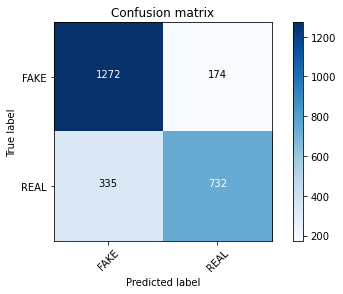

In [15]:
pred = classifier.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [16]:
# Tuning the multinomial NB model to different values of hyper parameter alpha
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,Y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(Y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.7544767210505372
Alpha: 0.1, Score : 0.7942697970553124
Alpha: 0.2, Score : 0.7962594508555512
Alpha: 0.30000000000000004, Score : 0.7986470354158376
Alpha: 0.4, Score : 0.7978511738957421
Alpha: 0.5, Score : 0.7978511738957421
Alpha: 0.6000000000000001, Score : 0.7974532431356944
Alpha: 0.7000000000000001, Score : 0.7974532431356944
Alpha: 0.8, Score : 0.7986470354158376
Alpha: 0.9, Score : 0.7986470354158376


In [17]:
val = classifier.predict(validation_df)
val

array([1, 1, 1, ..., 1, 1, 1])

[0.73235294 0.77941176 0.74215686 0.7372549  0.74705882]
[0 0 1 ... 1 0 0]
accuracy:   0.754
Confusion matrix, without normalization


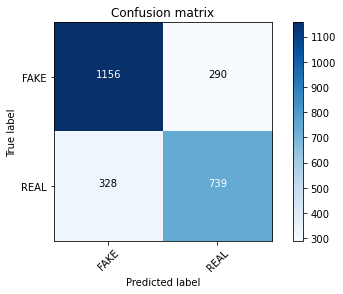

In [18]:
# Using ridge regression to fit the model
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
clf_ridge = linear_model.RidgeClassifier(alpha = 0.1)
scores_ridge = cross_val_score(clf_ridge, X_train, Y_train, cv=5)
print(scores_ridge)
clf_ridge.fit(X_train, Y_train)
pred = clf_ridge.predict(X_test)
print(pred)
score = metrics.accuracy_score(Y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.750
Confusion matrix, without normalization


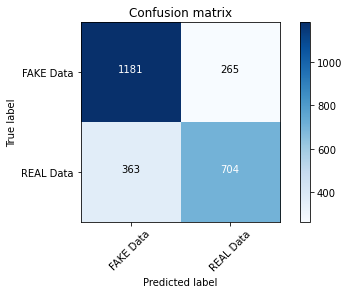

In [19]:
# Using PassiveAggressiveClassifier to fit the model
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=50)
linear_clf.fit(X_train, Y_train)
pred = linear_clf.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

accuracy:   0.750
Confusion matrix, without normalization


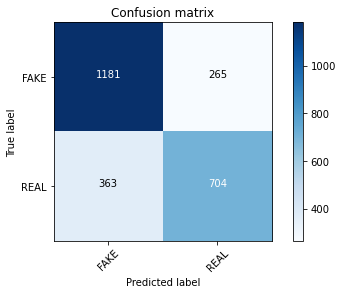

In [20]:
# Using random forest classifier to fit the model
from sklearn.ensemble import RandomForestClassifier #Random Forest Classifier module
forest = RandomForestClassifier(n_estimators = 100)
forest = forest.fit(X_train,Y_train)
forest_result = forest.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [21]:
validation_data

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [22]:
val = pd.DataFrame(val, columns = ['target'])
val

,target
0,1
1,1
2,1
3,1
4,1
...,...
3258,1
3259,0
3260,1
3261,1


In [23]:
index = validation_data[['id']]
index

,id
0,0
1,2
2,3
3,9
4,11
...,...
3258,10861
3259,10865
3260,10868
3261,10874


In [24]:
submission = pd.concat([index,val],axis = 1)
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [25]:
submission.to_csv('submission.csv', index = False)

### Using Word2Vec
### Creating a corpus from the multiple tweet datasets
### source of datasets
* 
* https://www.kaggle.com/crowdflower/twitter-user-gender-classification
* https://data.world/crowdflower/apple-twitter-sentiment 
* https://www.kaggle.com/c/nlp-getting-started/data

In [26]:
# loading the data from sources into respective dataframes
# apple_twitter_sentiment = pd.read_csv("/Users/saishdesai/Documents/NLP/Disaster_tweet_prediction/data/Word2vec_Training_data/Apple_Twitter_Sentiment/Apple-Twitter-Sentiment-DFE.csv", encoding = "latin-1")
# apple_twitter_sentiment                                                                                                                                                 

# twitter_gender_classification = pd.read_csv("/Users/saishdesai/Documents/NLP/Disaster_tweet_prediction/data/Word2vec_Training_data/Twitter_gender_classification/gender-classifier-DFE-791531.csv", encoding = "latin-1")
# twitter_gender_classification

# covid19_tweets = pd.read_csv("/Users/saishdesai/Documents/NLP/Disaster_tweet_prediction/data/Word2vec_Training_data/covid19_tweets/covid19_tweets.csv")

# processed_tweets = []
# tweet_data = []

# cleaning the apple sentiment data
# for tweet in covid19_tweets['text']:
#    processed_tweets = text_clean_preprocess(tweet)
#    tweet_data.append(processed_tweets)

# cleaning the apple sentiment data
# for tweet in apple_twitter_sentiment['text']:
#     processed_tweets = text_clean_preprocess(tweet)
#     tweet_data.append(processed_tweets)

# cleaning the gender classification data

# for tweet in twitter_gender_classification['text']:
#     processed_tweets = text_clean_preprocess(tweet)
#     tweet_data.append(processed_tweets)
# adding the tweets to the pre-processed tweets of the training dataset
#tweet_data = tweet_data + clean_tweets

In [27]:
tweet_data  = clean_tweets
sentences = []
for ele in tweet_data:
    sentences.append(ele.split())

validation_sentences = []
for ele in clean_tweets_validation:
    validation_sentences.append(ele.split())

In [29]:
from gensim.models import Word2Vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 1000    # Word vector dimensionality                      
min_word_count = 100   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 50          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [39]:
model = Word2Vec(sentences, workers=num_workers, \
             vector_size=num_features, min_count = min_word_count, \
             window = context, sample = downsampling,sg=1)


# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

2022-01-25 23:19:53,597 : INFO : collecting all words and their counts
2022-01-25 23:19:53,599 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-01-25 23:19:53,633 : INFO : collected 18197 word types from a corpus of 85531 raw words and 7613 sentences
2022-01-25 23:19:53,634 : INFO : Creating a fresh vocabulary
2022-01-25 23:19:53,642 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=100 retains 110 unique words (0.6044952464691982%% of original 18197, drops 18087)', 'datetime': '2022-01-25T23:19:53.642946', 'gensim': '4.0.1', 'python': '3.8.12 (default, Oct 12 2021, 06:23:56) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2022-01-25 23:19:53,644 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=100 leaves 22877 word corpus (26.747027393576598%% of original 85531, drops 62654)', 'datetime': '2022-01-25T23:19:53.644189', 'gensim': '4.0.1', 'python': '3.8.12 (default, Oct 12 2021, 06:23:56

In [34]:
# list of all the words which are in the model vocabulary
mod_vocab = model.wv.index_to_key # vocabulary captured by the word2veec algorithm
mod_vocab = sorted(set(mod_vocab))
# calculating a vector average for all words in a given tweet
def wordvec_avg(tweet,model, num_features):
    """
    A function to generate an vector is the average of all the words used in a tweet
    """
    feature_vec = np.zeros((num_features,),dtype="float32") # initializing a feature vector each tweet
    word_count = 0 # count of all the words in a tweet
    for word in tweet:
        if word in mod_vocab:
            word_count += 1               
            feature_vec = np.add(feature_vec,model.wv[word])
    feature_vec = np.divide(feature_vec,word_count) # dividing the vector addition result with the number of words encountered to get the avg
    return feature_vec
count=0
# Array to store corresponding vector for each tweet in the training data set
data_array = np.zeros((len(sentences),num_features),dtype="float32")
count = 0 # counter for tweet number
for sent in sentences:
    data_array[count] = wordvec_avg(sent, model, num_features )
    count+=1
word2vec_data = pd.DataFrame(data_array)
word2vec_data = pd.concat([word2vec_data,clean_data['target']],axis=1)
word2vec_data = word2vec_data.dropna(axis=0,how='any') # dropping rows for all the missing values

# Array to store corresponding vector for each tweet in the validation data set
validation_array = np.zeros((len(validation_sentences),num_features),dtype="float32")
val_count = 0 # counter for tweet number
for val_sent in validation_sentences:
    validation_array[val_count] = wordvec_avg(val_sent, model, num_features )
    val_count+=1
word2vec_val_data = pd.DataFrame(validation_array)
word2vec_val_data = word2vec_val_data.dropna(axis=0,how='any') # dropping rows for all the missing values)
            

NameError: name 'model' is not defined

In [ ]:
# np.any(np.isnan(numpy_array)) - code to check if any numpy array has nan values 
# np.all(np.isfinite(numpy_array)) - code to check if all elements of a numpy array are finite
    

In [ ]:
# Splitting the vectorized data into training and testing set
X_train, X_test,Y_train, Y_test = train_test_split(word2vec_data.drop(['target'],axis=1),word2vec_data['target'], test_size=0.33, random_state=42)

In [ ]:
# Using random forest classifier to fit the model
from sklearn.ensemble import RandomForestClassifier #Random Forest Classifier module
forest = RandomForestClassifier(n_estimators = 500)
forest = forest.fit(X_train,Y_train)
forest_result = forest.predict(X_test)
score = metrics.accuracy_score(Y_test, forest_result)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, forest_result)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# https://imerit.net/blog/top-25-twitter-datasets-for-natural-language-processing-and-machine-learning-all-pbm/
# Training a word2vec model